In [1]:
#!pip install pandas --upgrade  --quiet
#!pip install numpy --upgrade  --quiet
#!pip install scipy --upgrade  --quiet
#!pip install statsmodels --upgrade  --quiet
#!pip install scikit-learn --upgrade  --quiet
#!pip install missingno --upgrade  --quiet
#!pip install torch --upgrade --quiet
!pip install apafib --upgrade --quiet

Objetivos de aprendizaje:
1. Conocer el análisis de problemas usando máquinas de soporte vectorial, árboles de decisión y conjuntos de clasificadores
2. Interpretar modelos de árboles de decisión
3. Usar técnicas de relevancia de atributos sobre clasificadores no lineales

# Problema 2: Esa música me hace sentir ...
El poder clasificar la música de manera automática a partir de las caracterísiticas de la onda
sonora tiene aplicaciones tanto para organizarla de manera coherente respecto a ciertos atribu-
tos subjetivos difíciles de medir, como para personalización en aplicaciones de streaming. Este
conjunto de datos de UCI1 plantea el clasificar canciones a partir de caracterísiticas espectrales
del sonido en cuatro emociones (relajado, triste, feliz, exaltado). El objetivo es tener un modelo
que pueda clasificar canciones de acuerdo con estas emociones.

Puedes obtener mediante la función load_musica de la librería apafib esta retornará un data-
frame de Pandas. Resuelve los siguientes apartados ilustrando los resultados de la manera que
te parezca más adecuada.

Cabe destacar que según el enunciado, en https://archive.ics.uci.edu/dataset/862/turkish+music+emotion se puede encontrar la descripción de las variables, pero al ir a esta web no había ninguna descripción de todas las variables, solo una muy breve descripción del caracter general del conjunto (nada respecto a ninguna variable individualmente).

## Imports

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

from time import time
from datetime import timedelta

init_time = time()

In [3]:
import pandas as pd
import numpy as np
from numpy.random import choice
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import set_config
from sklearn import svm
from matplotlib.colors import ListedColormap
from sklearn.metrics import ConfusionMatrixDisplay, classification_report,  RocCurveDisplay, PrecisionRecallDisplay, accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from yellowbrick.classifier.rocauc import roc_auc
from yellowbrick.target.feature_correlation import feature_correlation
from yellowbrick.classifier import precision_recall_curve
from tqdm.notebook import tqdm
from torch.utils.data import Dataset
from scipy import stats
from IPython.display import display

from apafib import load_musica

import warnings
set_config(display='text')
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 16})
pd.set_option('display.precision', 3)

In [4]:
def save_results(clf, X_test, y_test, nclf, df):
    if hasattr(clf, 'best_score_'):
        df.loc[nclf,'train XV acc'] = clf.best_score_
    else:
        df.loc[nclf,'train XV acc'] = np.nan
    df.loc[nclf,'test acc'] = accuracy_score(y_test, clf.predict(X_test))
    df.loc[nclf,'precision score (M)'] = precision_score(y_test, clf.predict(X_test), average='macro')
    df.loc[nclf,'recall score (M)'] = recall_score(y_test, clf.predict(X_test), average='macro')
    df.loc[nclf,'f1 score (M)'] = f1_score(y_test, clf.predict(X_test), average='macro')
    return df

results_df = pd.DataFrame()

Primero de todo, cargamos los datos, y realizamos una mínima exploración para ver las dimensiones de estos, así como los missing values, la matriz de correlación de los atributos y las distribuciones de estos.

Dimensiones: (400, 51)

Tipos de variables:
float64    50
object      1
Name: count, dtype: int64

Missing values de cada columna:
Class                                             0
_RMSenergy_Mean                                   0
_Lowenergy_Mean                                   0
_Fluctuation_Mean                                 0
_Tempo_Mean                                       0
_MFCC_Mean_1                                      0
_MFCC_Mean_2                                      0
_MFCC_Mean_3                                      0
_MFCC_Mean_4                                      0
_MFCC_Mean_5                                      0
_MFCC_Mean_6                                      0
_MFCC_Mean_7                                      0
_MFCC_Mean_8                                      0
_MFCC_Mean_9                                      0
_MFCC_Mean_10                                     0
_MFCC_Mean_11                                     0
_MFCC_Mean_12                        

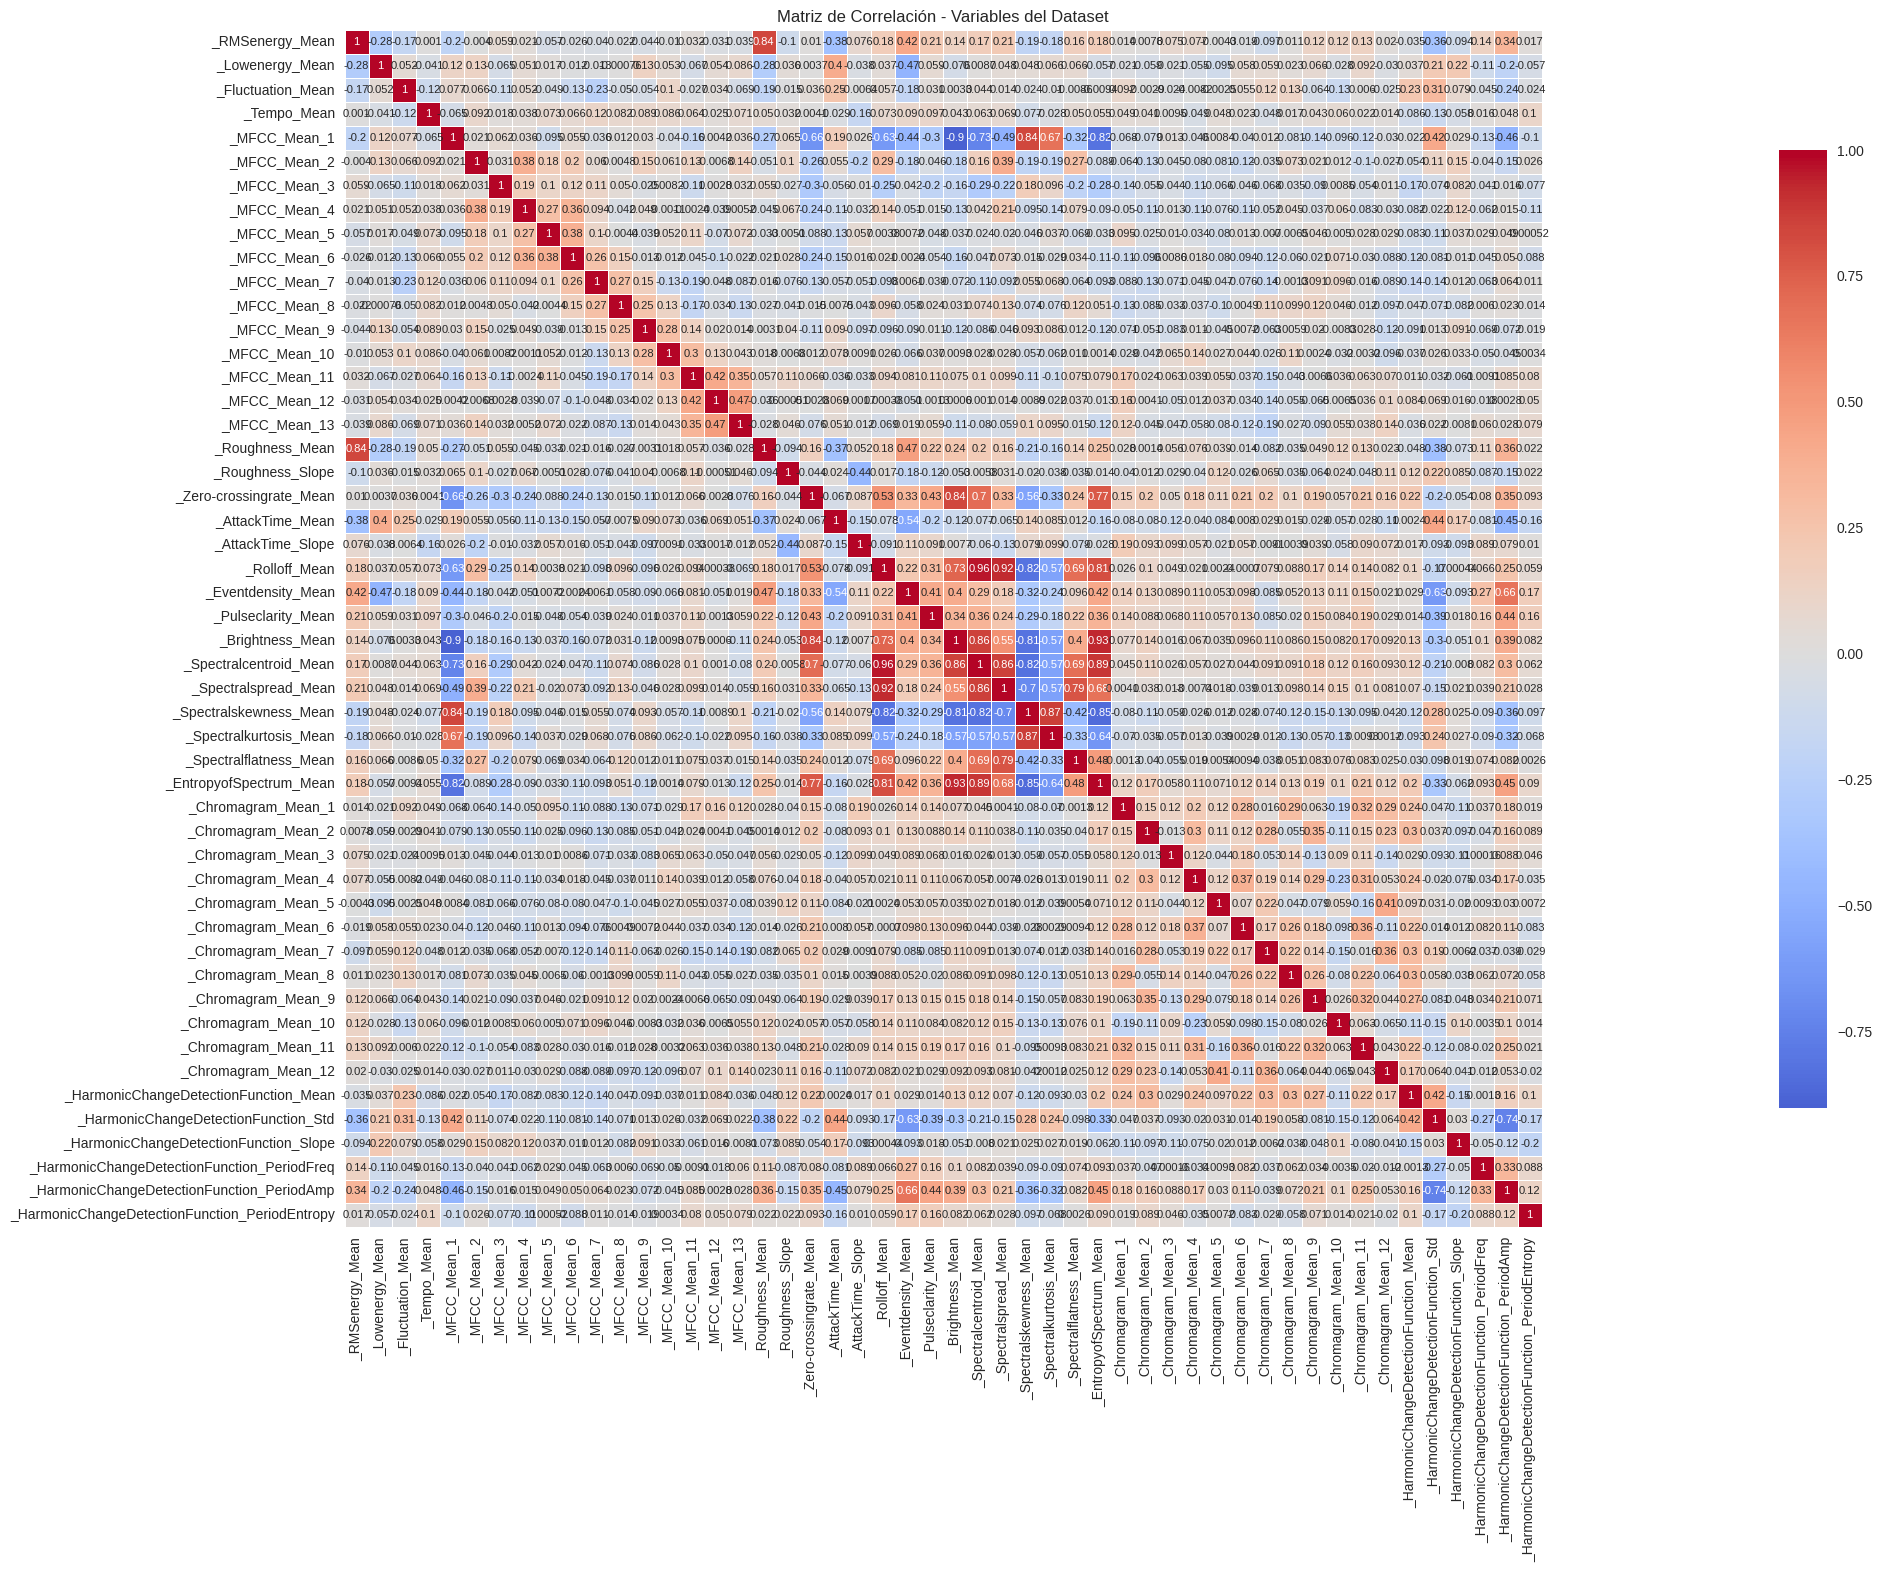


Distribuciones de las variables:


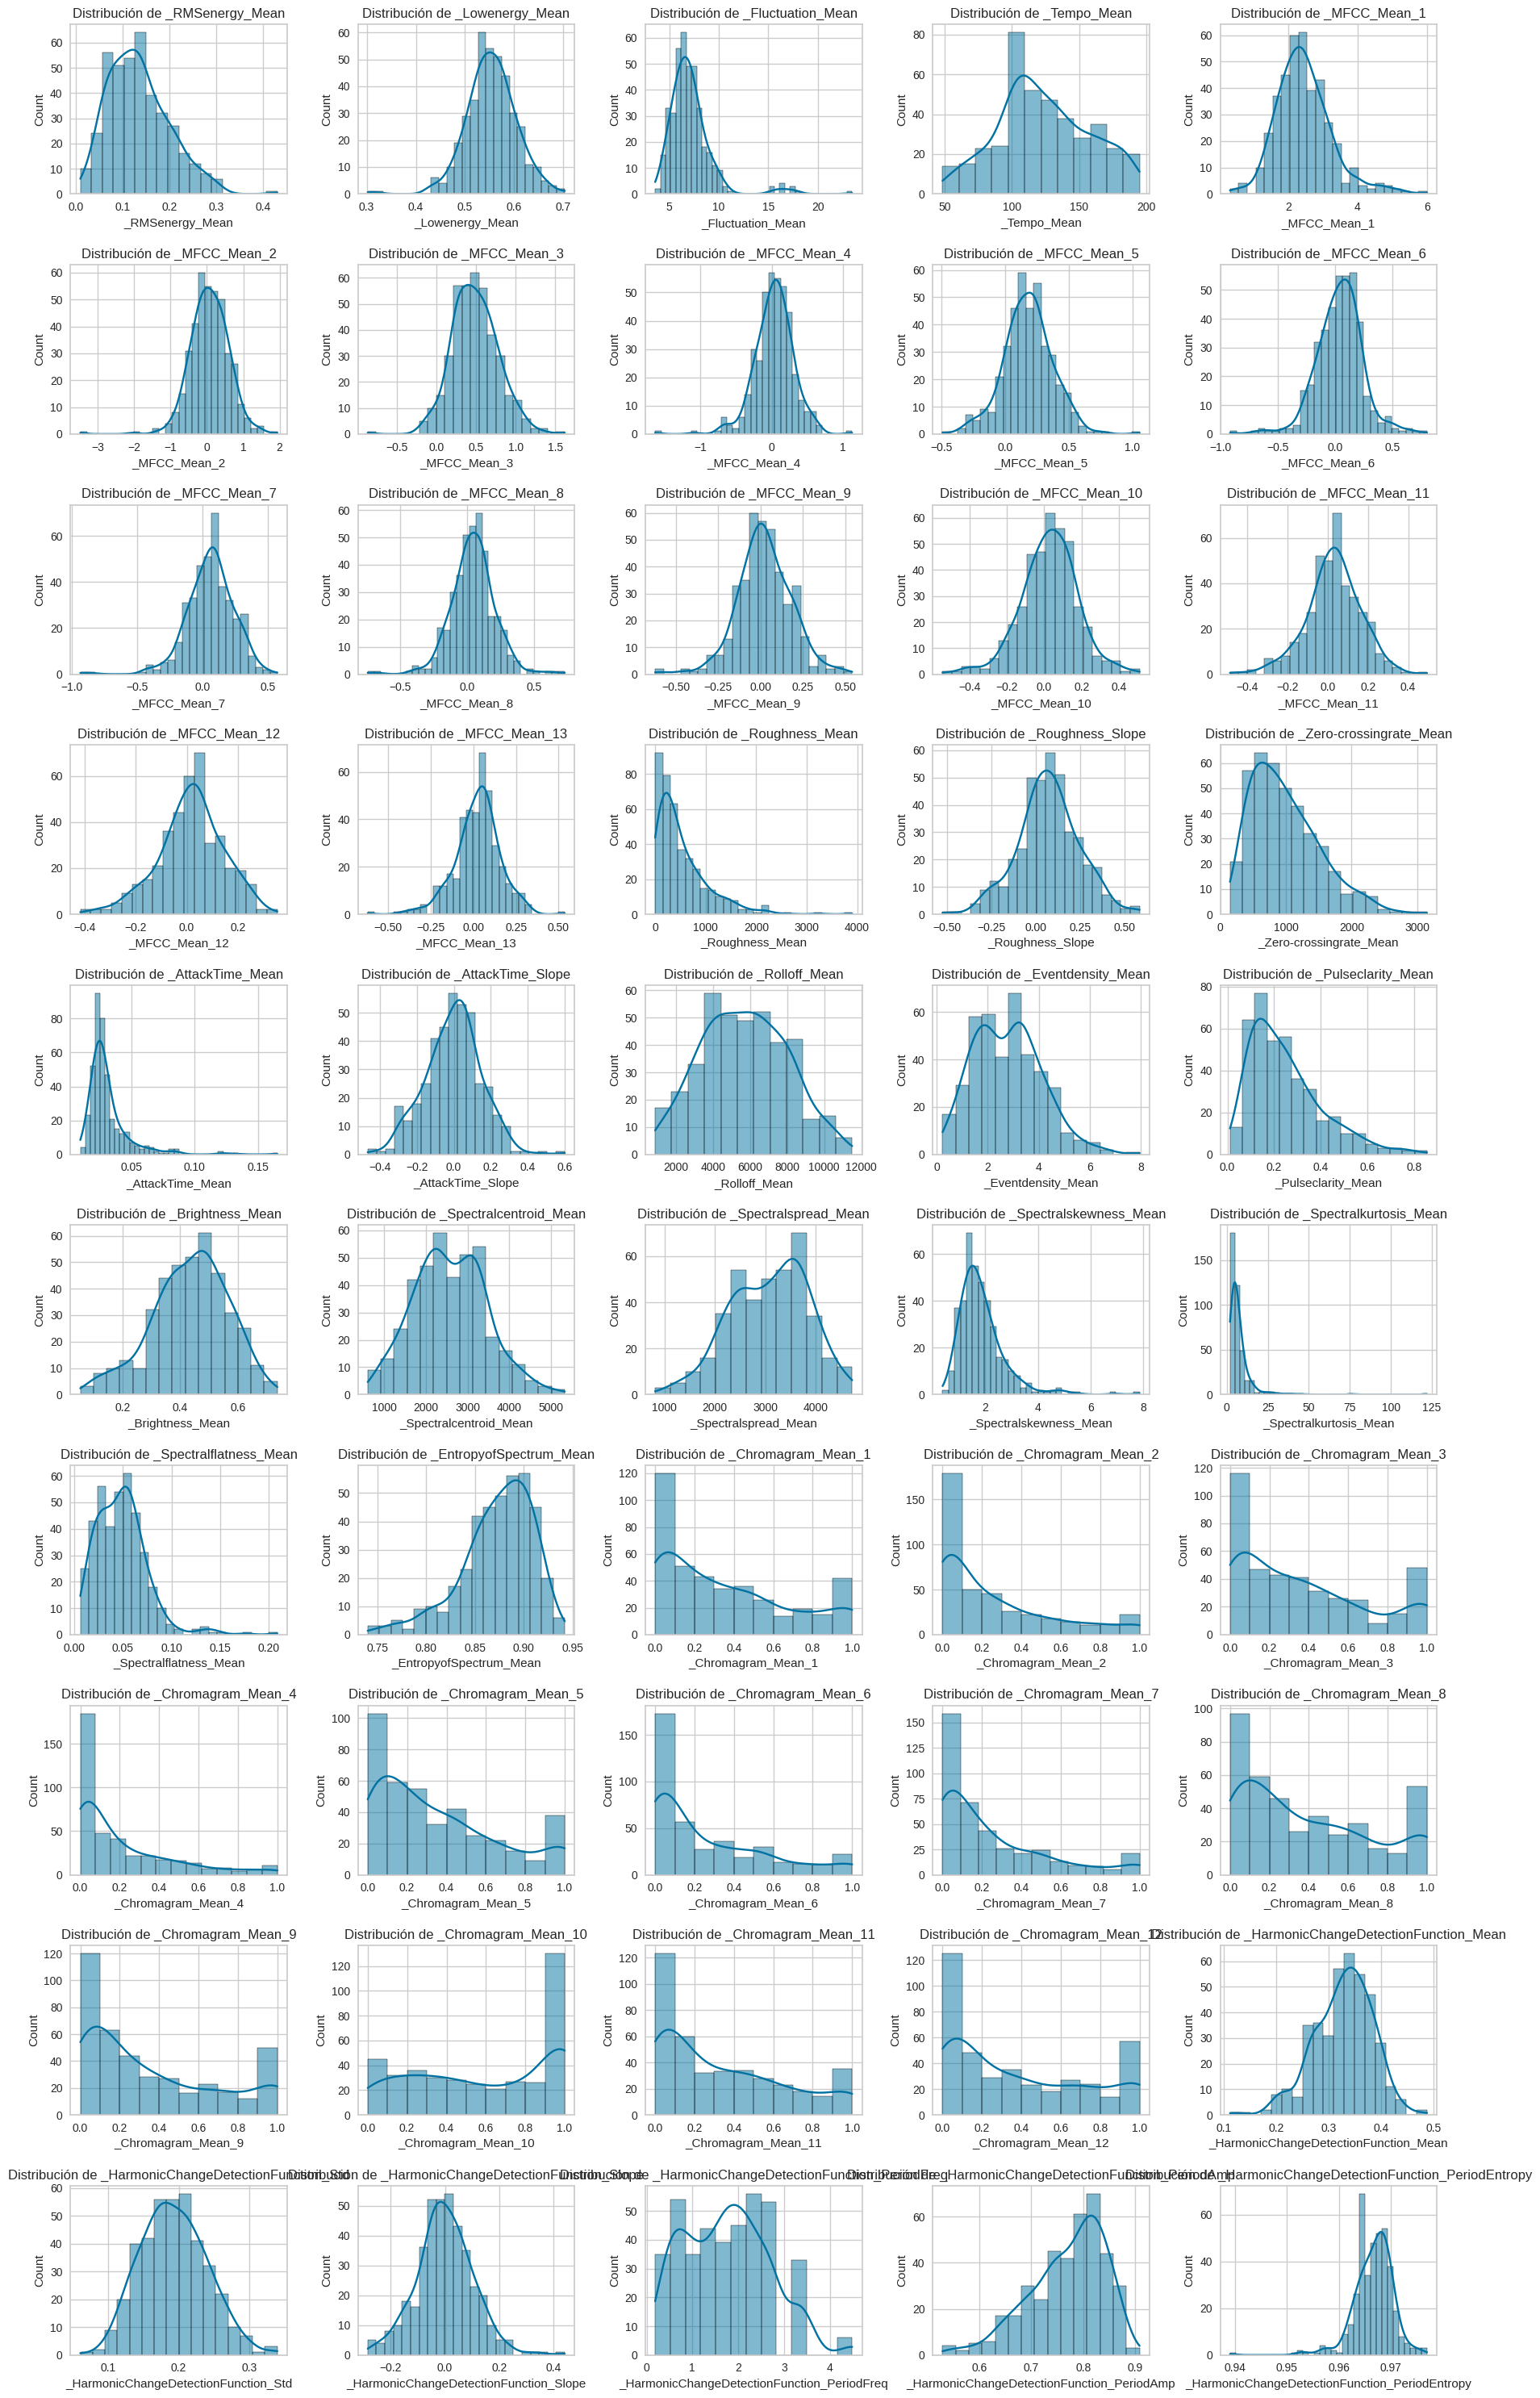


Distribución de la variable objetivo:


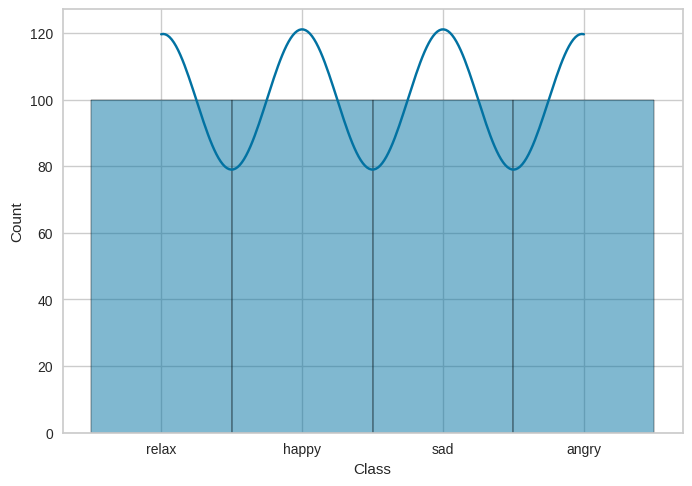


Cabecera del dataset:


Class  _RMSenergy_Mean  _Lowenergy_Mean  _Fluctuation_Mean  _Tempo_Mean  \
0  relax            0.052            0.591              9.136      130.043   
1  relax            0.125            0.439              6.680      142.240   
2  relax            0.046            0.639             10.578      188.154   
3  relax            0.135            0.603             10.442       65.991   
4  relax            0.066            0.591              9.769       88.890   

   _MFCC_Mean_1  _MFCC_Mean_2  _MFCC_Mean_3  _MFCC_Mean_4  _MFCC_Mean_5  ...  \
0         3.997         0.363         0.887         0.078         0.221  ...   
1         4.058         0.516         0.785         0.397         0.556  ...   
2         2.775         0.903         0.502         0.329         0.287  ...   
3         2.841         1.552         0.612         0.351         0.011  ...   
4         3.217         0.228         0.814         0.096         0.434  ...   

   _Chromagram_Mean_9  _Chromagram_Mean_10  _Chromagram_Mean_11  \
0               0.426                1.000                0.008   
1               0.002                1.000                0.000   
2               0.184                0.746                0.016   
3               0.038                1.000                0.161   
4               0.004                0.404                1.000   

   _Chromagram_Mean_12  _HarmonicChangeDetectionFunction_Mean  \
0                0.101                                  0.316   
1                0.984                                  0.285   
2                1.000                                  0.413   
3                0.757                                  0.422   
4                0.001                                  0.345   

   _HarmonicChangeDetectionFunction_Std  \
0                                 0.261   
1                                 0.211   
2                                 0.299   
3                                 0.265   
4                                 0.261   

   _HarmonicChangeDetectionFunction_Slope  \
0                                   0.018   
1                                  -0.082   
2                                   0.134   
3                                   0.042   
4                                   0.089   

   _HarmonicChangeDetectionFunction_PeriodFreq  \
0                                        1.035   
1                                        3.364   
2                                        1.682   
3                                        0.354   
4                                        0.748   

   _HarmonicChangeDetectionFunction_PeriodAmp  \
0                                       0.593   
1                                       0.702   
2                                       0.692   
3                                       0.743   
4                                       0.674   

   _HarmonicChangeDetectionFunction_PeriodEntropy  
0                                           0.970  
1                                           0.967  
2                                           0.963  
3                                           0.968  
4                                           0.957  

[5 rows x 51 columns]

In [5]:
musica = load_musica()
print(f"Dimensiones: {musica.shape}")
print(f"\nTipos de variables:")
print(musica.dtypes.value_counts())
print(f"\nMissing values de cada columna:")
print(musica.isnull().sum())
print(f"\nMatriz de correlaciones:")
plt.figure(figsize = (48, 16));
sns.heatmap(musica.select_dtypes(include=['number']).corr(), cmap = 'coolwarm', center = 0, square = True, linewidths = 0.5, cbar_kws = {"shrink": 0.8}, annot = True, annot_kws = {'size': 8});
plt.title('Matriz de Correlación - Variables del Dataset');
plt.tight_layout();
plt.show();
print(f"\nDistribuciones de las variables:")
plt.figure(figsize = (18, 30));
for i, col in enumerate(musica.drop('Class', axis = 1).columns, 1):
    plt.subplot(10, 5, i);
    sns.histplot(musica[col], kde = True);
    plt.title(f"Distribución de {col}");
plt.tight_layout();
plt.show();
print(f"\nDistribución de la variable objetivo:")
sns.histplot(musica['Class'], kde = True);
plt.show();
print(f"\nCabecera del dataset:")
display(musica.head());

Podemos ver que todas las variables son numéricas (50 decimales), menos la variable objetivo $Class$, que es una variable qualitativa con cuatro posibles valores (relax, happy, sad y angry). Además podemos observar que no hay ningun missing value, así que no tendremos que imputar los valores perdidos. Viendo la matriz de correlaciones podemos observar que hay bastantes variables con altas correlaciones (>0.8 o <-0.8). Observamos que la mayoría de variables siguen una distribución normal, y que la variable objetivo esta totalmente balanceada (100 elementos de cada una de las cuatro clases).

## a)
### Divide el conjunto de datos en entrenamiento y test (80%/20%).
Es muy importante estratificar la división de datos en train y test ya que el tamaño del dataset es pequeño.

In [7]:
X = musica.drop('Class', axis = 1)
Y = musica['Class']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y, random_state = 22)

# escalamos los datos: LR y SVMs lo necesitan (por tanto StackedClassifier también). Random forest no se ve afectado por esta transformación
mms = MinMaxScaler().fit(X_train)
X_train_sc = mms.transform(X_train)
X_test_sc = mms.transform(X_test)

print(f"Dimensiones de train: {X_train.shape}. Dimensiones de test: {X_test.shape}")

Dimensiones de train: (320, 50). Dimensiones de test: (80, 50)


Vemos que las dimensiones de los conjuntos son correctas, de forma que en train hay el 80% de los datos, y en test el 20% restante. A parte de dividir el conjunto de datos, se ha aplicado un escalado de estos ya que LR y los modelos de SVM lo necesitan (por tanto StackedClassifier también) mientras que random forest no se ve afectado por esta transformación. Por tanto, usaremos estos datos escalados para todos los modelos.


### El conjunto de datos solo tiene variables continuas y no hay valores perdidos. Aplica reducción de dimensionalidad con PCA y t-SNE y representa la variable respuesta sobre la transformación, ¿parece haber alguna relación entre las variables con la variable respuesta? ¿Podrían ser las clases linealmente separables?

Empezaremos por PCA:

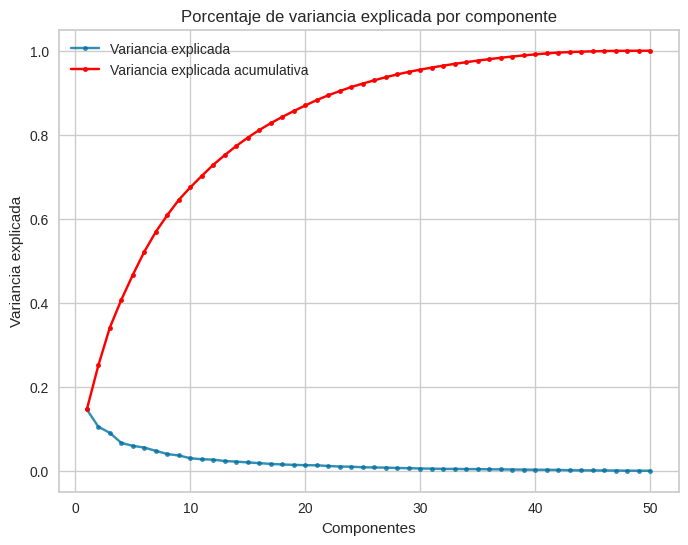

In [8]:
pca = PCA().fit(X_train_sc)

fig = plt.figure(figsize = (8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_ ) + 1), pca.explained_variance_ratio_, alpha = 0.8, marker = '.', label = "Variancia explicada")
y_label = plt.ylabel('Variancia explicada')
x_label = plt.xlabel('Componentes')
plt.plot(range(1, len(pca.explained_variance_ratio_ ) + 1), np.cumsum(pca.explained_variance_ratio_), c = 'red', marker = '.', label="Variancia explicada acumulativa")
plt.legend()
plt.title('Porcentaje de variancia explicada por componente');

Podemos ver que el primer componente explica menos del 20% de la variancia de los datos, y que se necesitan hasta 15 componentes para explicar el 80% de la variancia de los datos, y para explicar el 90% de la variancia de los datos se necesitan 24 componentes.

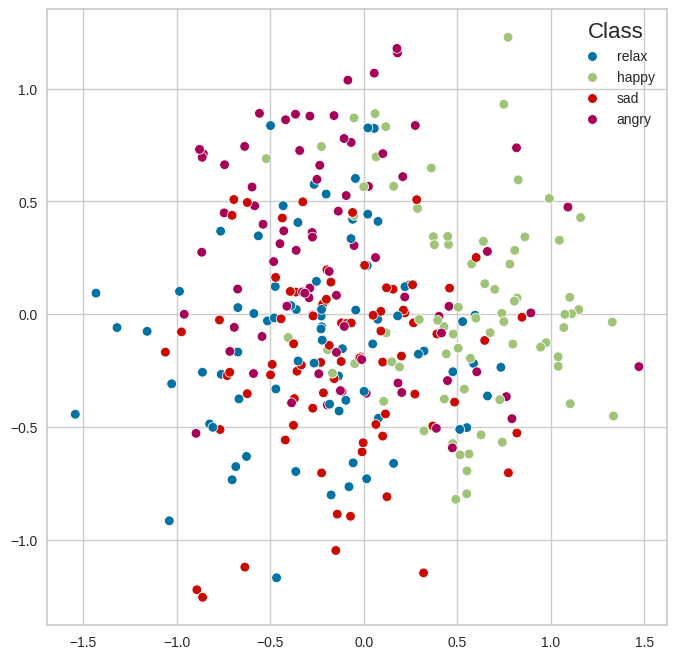

In [10]:
X_trans = pca.transform(X_train_sc)
fig = plt.figure(figsize = (8, 8))
sns.scatterplot(x = X_trans[:, 0], y = X_trans[:, 1], hue = Y_train);

En esta representación del PCA, todas las clases aparecen bastante solapadas y agrupadas, así que no parece que haya mucha separabilidad de clases. La clase **happy** está más centrada hacia la derecha (eje positivo de la primera componente) así que si que parece ser separable del resto, pero las otras clases estan bastante solapadas entre sí (y un poco también con la classe **happy**).

A continuación realizamos t_SNE:

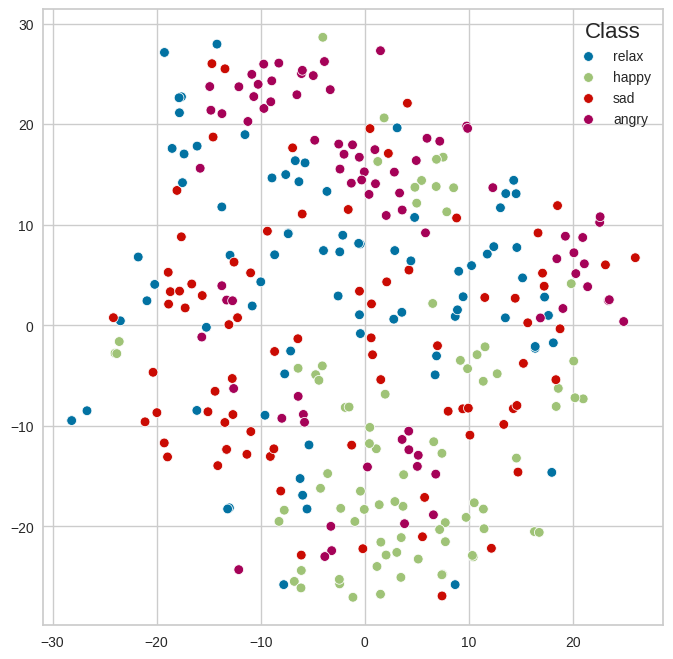

In [11]:
X_trans = TSNE(n_components = 2, perplexity = 20, max_iter = 2000, init = 'pca').fit_transform(X_train_sc)
fig = plt.figure(figsize = (8, 8))
sns.scatterplot(x = X_trans[:, 0], y = X_trans[:, 1], hue = Y_train);

A diferencia de con el PCA, el t-SNE muestra algunos patrones para separar las clases. En este caso, la clase **happy** parece ser la más separable del resto ya que esta centrada mayoritáriamente abajo (ejes negativos del eje vertical). En cuanto al resto de clases, no se aprecia la misma cantidad de solapamiento que sí aparece con la visualización del PCA.

## b)
### Vamos a entrenar primero un par de modelos como base de la calidad que se puede obtener con estos datos. Ajusta una regresión logística y una SVM lineal explorando adecuadamente sus hiperparámetros. Evalúa la calidad de los modelos.

Empezaremos evaluando un modelo de regresión logística. Realizaremos una exploración en rejilla para optimizar los hiperparámetros de la regresión logística para obtener nuestro modelo base.

In [10]:
lr = LogisticRegression(max_iter = 3000, solver = 'saga', random_state = 22) # el solver default (lbfgs) no soporta penalización l1. Para usar penalización l1 y l2 en clasificación multiclase usamos el solver saga
param = {'penalty':['l1', 'l2'], 'C': 10**np.linspace(-3, 3, 21, endpoint = True)}
lr_gs =  GridSearchCV(lr, param, cv = 10, n_jobs = -1, refit = True);
lr_gs.fit(X_train_sc, Y_train);
show_html(pd.DataFrame(lr_gs.cv_results_).loc[:, ['params', 'mean_test_score', 'rank_test_score']].sort_values(by = 'rank_test_score').head().to_html());

Podemos ver que los tres de los cinco mejores modelos (entre ellos los dos primeros) usan l2. Nos quedaremos con el mejor de ellos para usarlo como modelo base. Podemos ver que el mejor modelo usa un valor de 1 para **C** (lo que representa un compromiso equilibrado entre la maximización del margen y la minimización del error en el conjunto de entrenamiento).

In [12]:
print(classification_report(Y_test, lr_gs.predict(X_test_sc), target_names = [str(x) for x in Y_test.unique()]))
results_df = save_results(lr_gs, X_test_sc, Y_test, 'Logistic', results_df)

              precision    recall  f1-score   support

       happy       0.75      0.75      0.75        20
         sad       0.95      0.90      0.92        20
       angry       0.75      0.75      0.75        20
       relax       0.57      0.60      0.59        20

    accuracy                           0.75        80
   macro avg       0.75      0.75      0.75        80
weighted avg       0.75      0.75      0.75        80



Vemos que la clase con mejores métricas es **sad**, mientras que la peor es **relax**. Cabe destacar que se observa una mejor accuracy en test (81.6%) que en train (75%), lo que sugiere indicios de overfitting moderado.

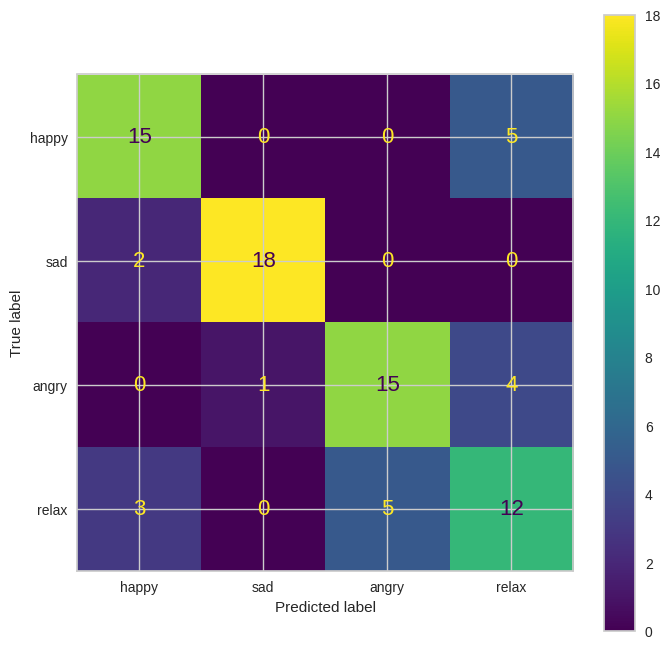

In [13]:
plt.figure(figsize = (8, 8));
ConfusionMatrixDisplay.from_estimator(lr_gs, X_test_sc, Y_test, display_labels = [str(x) for x in Y_test.unique()], ax = plt.subplot());

Observamos lo que acabamos de comentar: **relax** es la clase con peor precisión mientras que **sad** es la mejor.

Coeficientes de los atributos por clase:


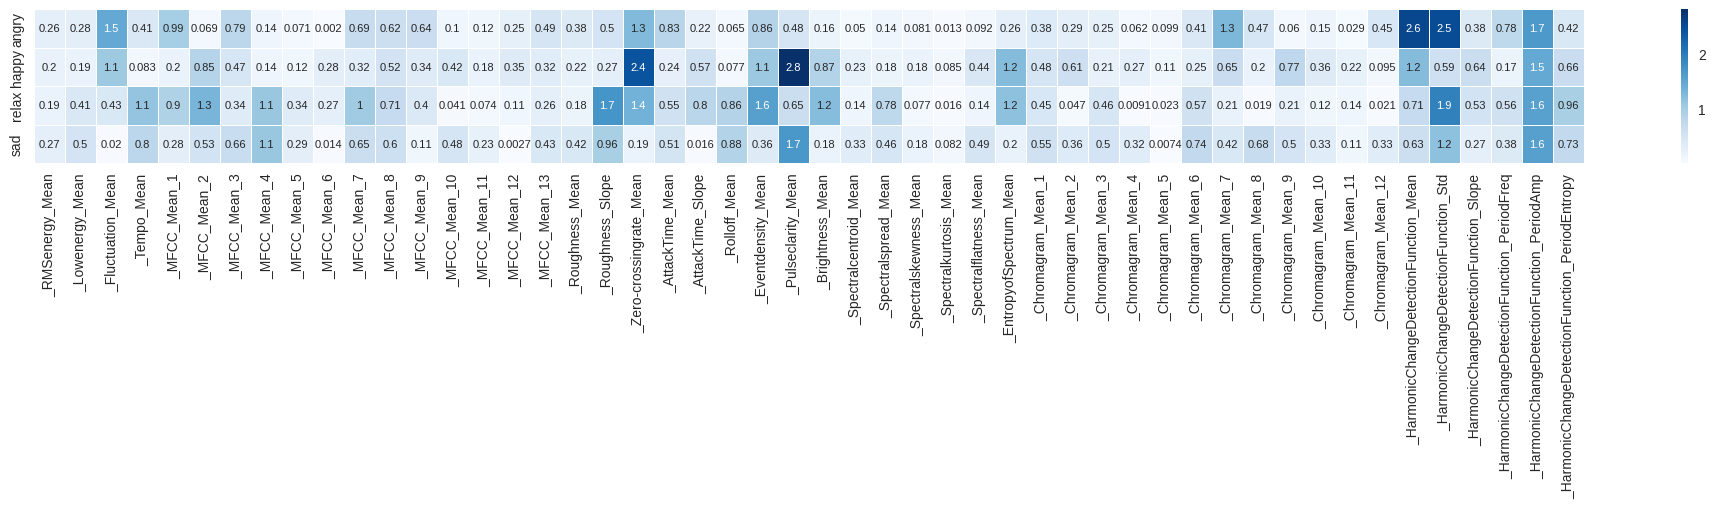


Coeficientes de los atributos (avg):


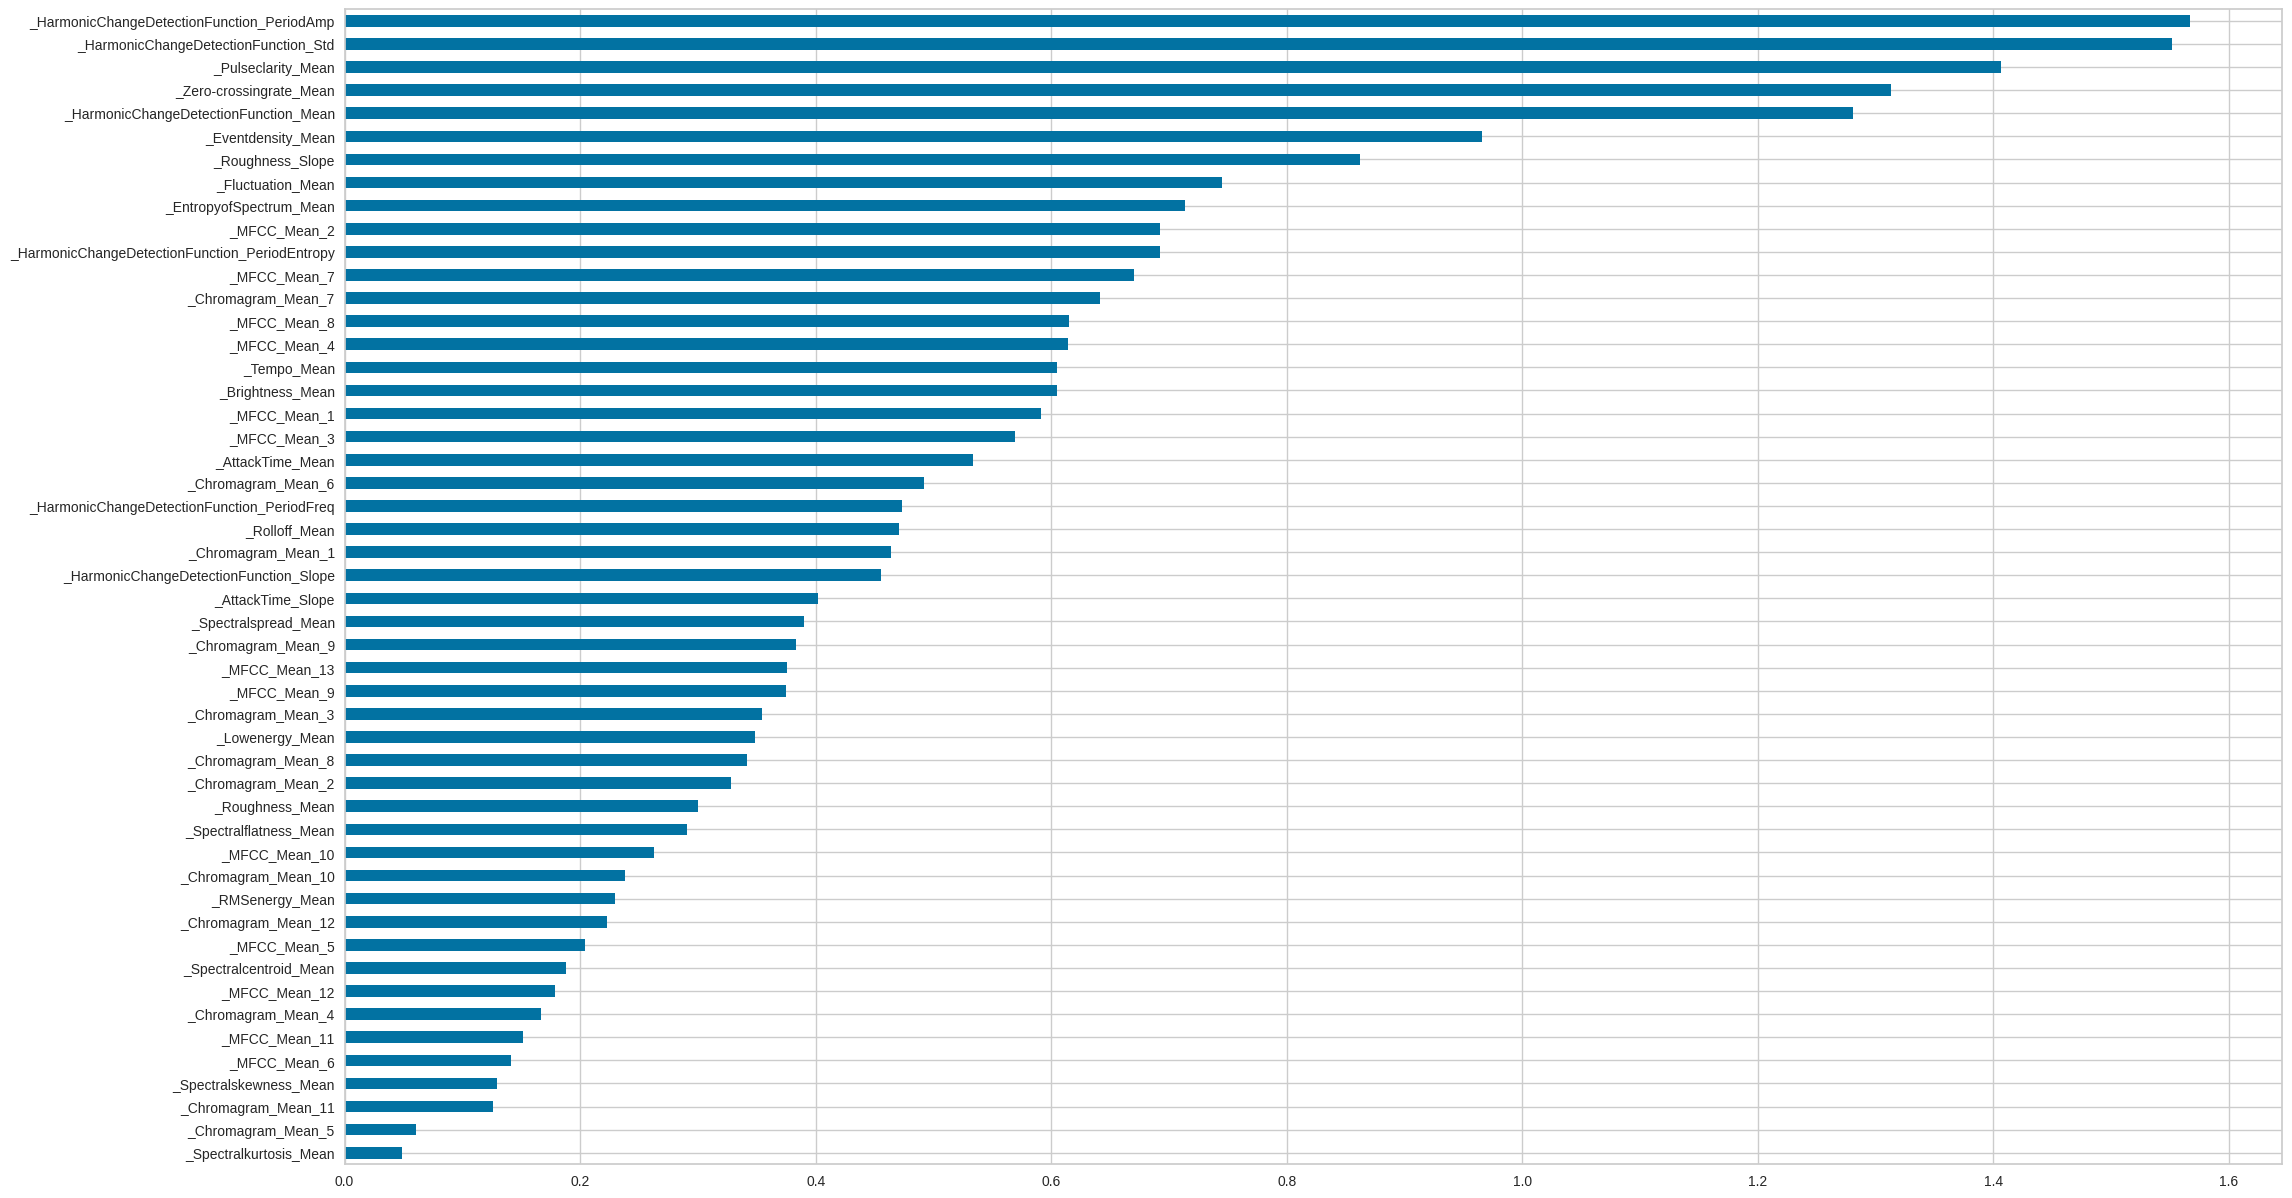

In [14]:
print('Coeficientes de los atributos por clase:')
coefs = pd.DataFrame(lr_gs.best_estimator_.coef_)
coefs.columns = X_train.columns
coefs.index = [str(x) for x in lr_gs.best_estimator_.classes_]
plt.figure(figsize = (25, 2));
sns.heatmap(coefs.abs(), annot = True, linewidths = .5, cbar = True, xticklabels = True, cmap = 'Blues', annot_kws = {'size': 8});
plt.show()

print('\n' + "Coeficientes de los atributos (avg):")
coefs = pd.DataFrame(lr_gs.best_estimator_.coef_)
coefs.columns = X_train.columns
importance = coefs.abs().mean(axis = 0)
importance.sort_values().plot.barh(figsize = (25, 15));

Mirando los valores obtenidos de los coeficientes de las ecuaciones logit, vemos que en este modelo, todas las variables tienen cierta importancia.

Mirando a los coeficientes de las ecuaciones logit, y luego el promedio de los 4 coeficientes (uno por ecuacion) de cada atributo, podemos ver que las 5 variables más importantes para este modelo de regresión logística son las siguientes:
1. _HarmonicChangeDetectionFunction_PeriodAmp
2. _HarmonicChangeDetectionFunction_Std
3. _Pulseclarity_Mean
4. _Zero-crossingrate_Mean
5. _HarmonicChangeDetectionFunction_Mean

A continuación evaluamos una SVM lineal. Realizaremos una exploración en rejilla para optimizar los hiperparámetros de la SVM lineal para obtener nuestro modelo base.

In [15]:
param = {'C':[1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]}
lsvc = svm.SVC(kernel = 'linear', probability = True, max_iter = 20000, random_state = 22)
glsvc = GridSearchCV(lsvc, param, cv = 5, n_jobs = -1, refit = True);
glsvc.fit(X_train_sc, Y_train);
show_html(pd.DataFrame(glsvc.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by = 'rank_test_score').to_html());

Podemos ver que el mejor modelo usa un valor de 1 para **C** (lo que representa un compromiso equilibrado entre la maximización del margen y la minimización del error en el conjunto de entrenamiento). Nos quedaremos con este modelo para usarlo como modelo base.

In [16]:
print(classification_report(Y_test, glsvc.predict(X_test_sc), target_names = [str(x) for x in Y_test.unique()]))
results_df = save_results(glsvc, X_test_sc, Y_test, 'SVM Linear', results_df)

              precision    recall  f1-score   support

       happy       0.78      0.70      0.74        20
         sad       0.90      0.90      0.90        20
       angry       0.75      0.75      0.75        20
       relax       0.59      0.65      0.62        20

    accuracy                           0.75        80
   macro avg       0.75      0.75      0.75        80
weighted avg       0.75      0.75      0.75        80



Observamos que la clase con peores metricas es (al igual que en logistic regression) **relax** y la mejor es **sad**. Además observamos una peor precisión en test (75%) que en train (78.1%), lo que indica indicios de overfitting, aunque muy moderado.

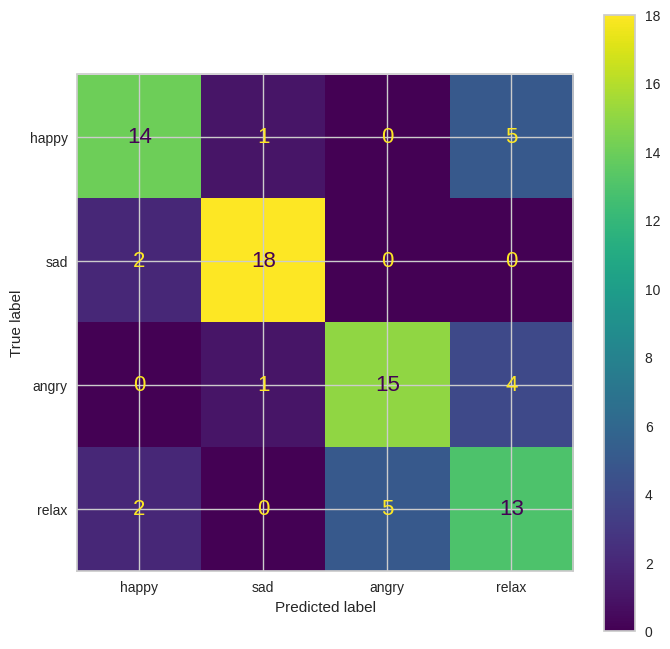

In [17]:
plt.figure(figsize = (8, 8));
ConfusionMatrixDisplay.from_estimator(glsvc, X_test_sc, Y_test, display_labels = [str(x) for x in Y_test.unique()], ax = plt.subplot());

Observamos lo que acabamos de comentar: **relax** es la clase con peor precisión mientras **sad** es la mejor.

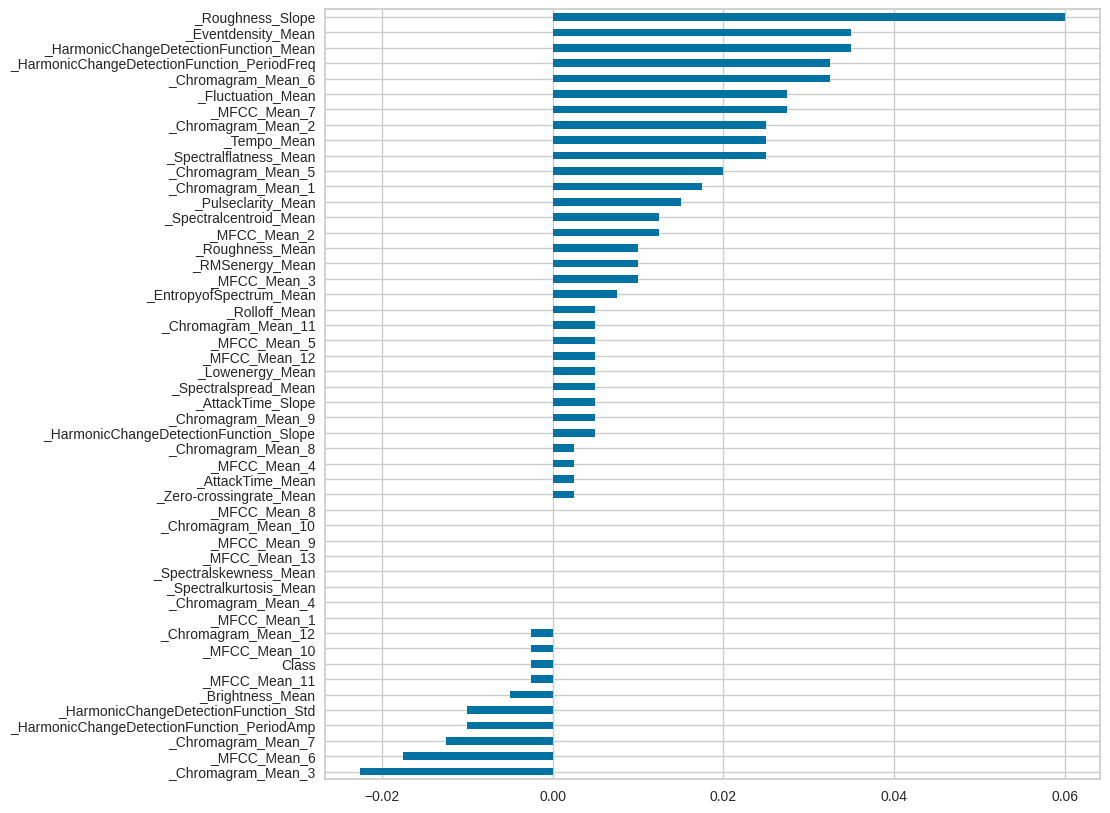

In [18]:
pi = permutation_importance(glsvc, X_test_sc, Y_test, n_jobs = -1, random_state = 22)
var_imp = pd.DataFrame({'importance': pi.importances_mean}, index = musica.columns[:-1])
var_imp.sort_values(by = 'importance').plot.barh(figsize = (10, 10), legend = False);

Mirando los valores obtenidos con permutation importance, vemos que en este modelo, hasta 32 variables tienen cierta importancia.

Mirando a los resultados de permutation importance, podemos ver que las 5 variables más importantes para este modelo de SVM lineal son:
1. _Roughness_Slope
2. _Eventdensity_Mean
3. _HarmonicChangeDetectionFunction_Mean
4. _HarmonicChangeDetectionFunction_PeriodFreq
5. _Chromagram_Mean_6

Podemos ver que de las 5 variables más importantes, solo 1 coincide con el modelo de regresión logística: _HarmonicChangeDetectionFunction_Mean.

Estos dos modelos base entrenados tienen un rendimiento bastante bueno y similar (81.6% en train y 75% en test para regresión logística y 78.1% en train y 75% en test para SVM lineal).

## c)
### Quizás introduciendo no linearidades en el modelo podremos obtener un mejor resultado. Entrena modelos SVM con kernel RBF ajustando adecuadamente sus hiperparámetros.
Realizaremos una exploración en rejilla para optimizar los hiperparámetros del modelo SVM con kernel RBF.

In [19]:
param = {'C':[1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6], 'gamma':['scale','auto']}
rbsvc =  svm.SVC(kernel = 'rbf', probability = True, max_iter = 20000, random_state = 22)
grbsvc =  GridSearchCV(rbsvc, param, cv = 5, n_jobs = -1, refit = True);
grbsvc.fit(X_train_sc, Y_train);
show_html(pd.DataFrame(grbsvc.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by = 'rank_test_score').head().to_html());

Podemos ver que 3 de los 5 mejores modelos usan scale aunque el mejor usa auto, y el mejor modelo usa un valor de 10 para **C** (lo que indica que prioriza la minimización del error frente a la maximización del margen en entrenamiento). Nos quedaremos con este modelo para usarlo como modelo base.

In [20]:
print(classification_report(Y_test, grbsvc.predict(X_test_sc), target_names = [str(x) for x in Y_test.unique()]))
results_df = save_results(grbsvc, X_test_sc, Y_test, 'SVM RBF', results_df)

              precision    recall  f1-score   support

       happy       0.72      0.65      0.68        20
         sad       0.86      0.90      0.88        20
       angry       0.71      0.75      0.73        20
       relax       0.55      0.55      0.55        20

    accuracy                           0.71        80
   macro avg       0.71      0.71      0.71        80
weighted avg       0.71      0.71      0.71        80



Por un lado, observamos que la clase con peores metricas es (al igual que en logistic regression y SVM lineal) **relax**, y la mejor clase sigue siendo **sad**. Por otro lado vemos que en train obtenemos una accuracy de 80% y en test baja hasta el 71%, lo que indica que hay cierto grado de overfitting.

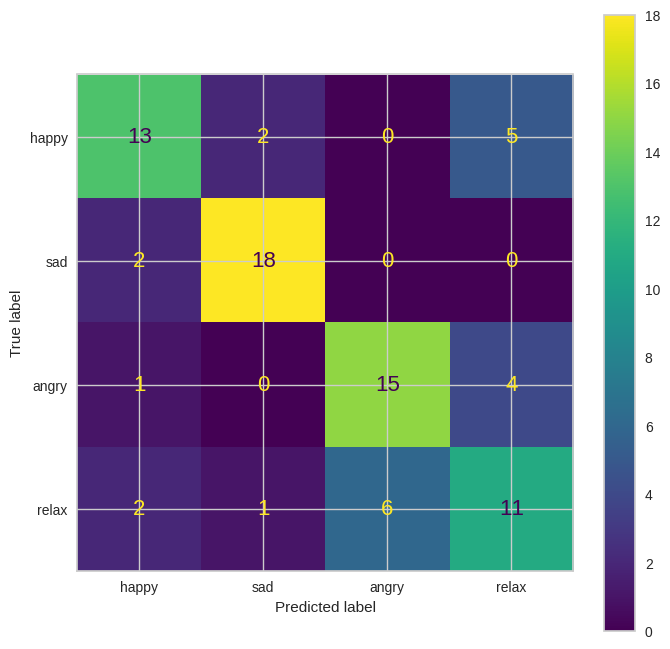

In [21]:
plt.figure(figsize = (8, 8));
ConfusionMatrixDisplay.from_estimator(grbsvc, X_test_sc, Y_test, display_labels = [str(x) for x in Y_test.unique()], ax = plt.subplot());

Observamos lo que acabamos de comentar: **relax** es la clase con peor precisión mientras que **sad** sigue siendo la mejor.

Vemos que este modelo tiene un rendimiento muy similar a los dos modelos base entrenados aunque es algo peor (80% en train y 71% en test).

### Calcula la permutation importance sobre el test para determinar qué atributos son más importantes en el modelo para predecir. Compara los atributos más importantes con los de los apartados anteriores. ¿Hay cierto acuerdo entre los modelos respecto a cuáles son los atributos más importantes?

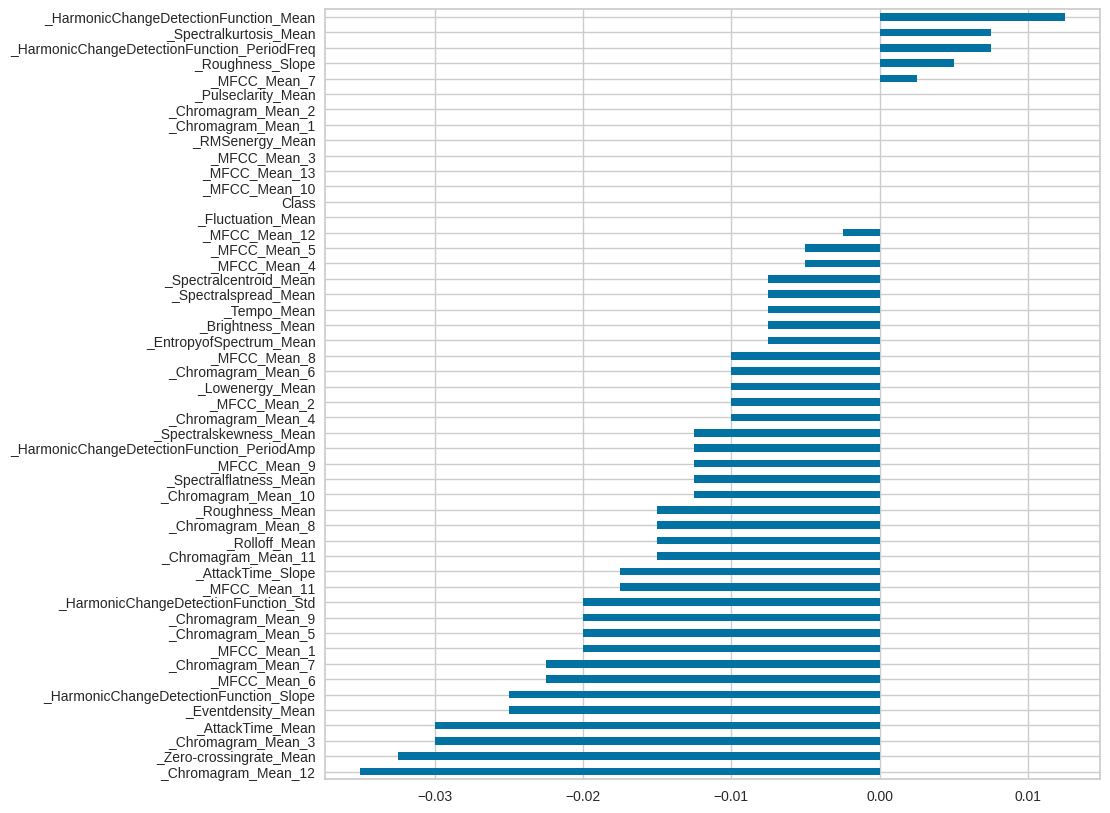

In [22]:
pi = permutation_importance(grbsvc, X_test_sc, Y_test, n_jobs = -1, random_state = 22)
var_imp = pd.DataFrame({'importance': pi.importances_mean}, index = musica.columns[:-1])
var_imp.sort_values(by = 'importance').plot.barh(figsize = (10, 10), legend = False);

Mirando los valores obtenidos con permutation importance, vemos que en este modelo, tansolo 5 variables tienen cierta importancia positiva.

Mirando a los resultados de permutation importance, podemos ver que las 5 variables más importantes para este modelo de SVM RBF son:
1. _HarmonicChangeDetectionFunction_Mean
2. _Spectralkurtosis_Mean
3. _HarmonicChangeDetectionFunction_PeriodFreq
4. _Roughness_Slope
5. _MFCC_Mean_7

Podemos ver que de las 5 variables más importantes, solo 1 coincide tanto con el modelo de regresión logística como con el de SVM lineal: _HarmonicChangeDetectionFunction_Mean. Además, hay otras dos que coinciden con el modelo de SVM Linear: _HarmonicChangeDetectionFunction_PeriodFreq y _Roughness_Slope.

Podemos ver que casi no hay acuerdo entre los modelos respecto a qué atributos son más importantes (solo 1 coincide en los tres modelos, aunque como mucho hay 3 variables en común en el top 5 de SVM RBF y SVM Linear).

## d)
### Los conjuntos de clasificadores permiten adaptarse mejor a la complejidad de los datos. Ajusta un random forest a los datos explorando adecuadamente sus hiperparámetros. Compara la calidad del modelo con los anteriores.
Realizaremos una exploración en rejilla para optimizar los hiperparámetros de este modelo de random forest.

In [23]:
param = {'n_estimators':[5, 10, 20, 30, 40, 50], 'criterion':['gini', 'entropy'], 'max_depth':[None, 3, 5, 7, 9, 11, 13, 15],'min_samples_leaf':[1, 2, 3, 5, 10]}
rf =  RandomForestClassifier(oob_score = True, random_state = 22)
grf =  GridSearchCV(rf, param, cv = 5, n_jobs = -1, refit = True);
grf.fit(X_train_sc, Y_train);
show_html(pd.DataFrame(grf.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by = 'rank_test_score').head().to_html());

Podemos ver los 4 mejores modelos usan gini y dan valor de 1 a **min_samples_leaf**, y 4 de los 5 mejores usan 40 estimadores. Los 4 mejores modelos (todos ellos con el mismo **mean_test_score**) usan un valor de None, 15, 13 y 13 respectivamente para **max_depth**. Nos quedaremos con el mejor modelo (el que aparece primero) para usarlo como modelo base.

In [24]:
print(classification_report(Y_test, grf.predict(X_test_sc), target_names = [str(x) for x in Y_test.unique()]))
results_df = save_results(grf, X_test_sc, Y_test, 'Random Forest', results_df)

              precision    recall  f1-score   support

       happy       0.79      0.75      0.77        20
         sad       0.80      0.80      0.80        20
       angry       0.72      0.90      0.80        20
       relax       0.62      0.50      0.56        20

    accuracy                           0.74        80
   macro avg       0.73      0.74      0.73        80
weighted avg       0.73      0.74      0.73        80



Por un lado, observamos que la clase con peores metricas es **relax**, mientras que la mejor clase es **sad** (al igual que en todos los modelos vistos. Por otro lado vemos que la precisión empeora en test respecto train (74% y 82.8% respectivamente). Esto indica que este modelo tiene overfitting.

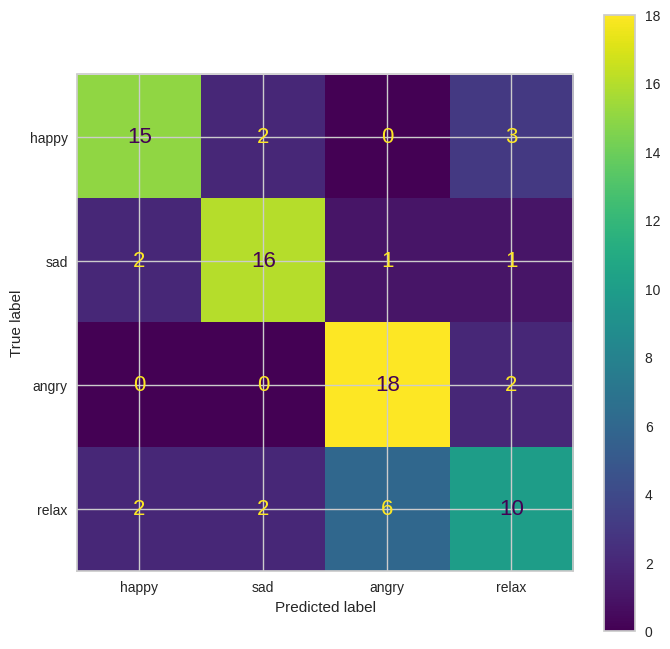

In [25]:
plt.figure(figsize = (8, 8));
ConfusionMatrixDisplay.from_estimator(grf, X_test_sc, Y_test, display_labels = [str(x) for x in Y_test.unique()], ax = plt.subplot());

Observamos lo que acabamos de comentar: **relax** es la clase con peor precisión, mientras que **sad** es la clase con mayor precisión

Este modelo es mejor que el SVM con kernel RBF y tiene un rendimiento muy similar a los modelos base, aunque su precisión en la clase **relax** es muy mala. Tiene la mejor precisión en train, aunque es de los que tiene más overfitting junto con el SVM RBF (82.8% en train y 74% en test).

### Calcula la permutation importance sobre el test para determinar qué atributos son más importantes en el modelo para predecir. Compara los atributos más importantes con los de los apartados anteriores. ¿Hay cierto acuerdo entre los modelos respecto a cuáles son los atributos más importantes?

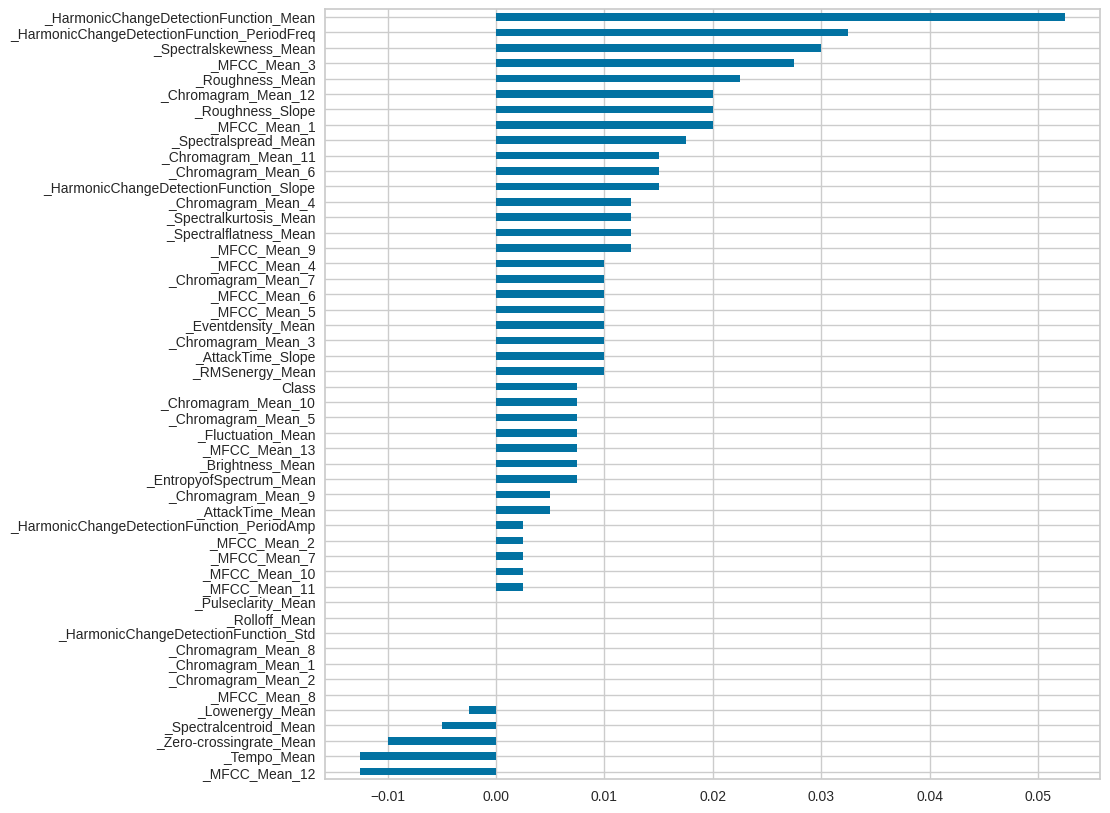

In [26]:
pi = permutation_importance(grf, X_test_sc, Y_test, n_jobs = -1, random_state = 22)
var_imp = pd.DataFrame({'importance': pi.importances_mean}, index = musica.columns[:-1])
var_imp.sort_values(by = 'importance').plot.barh(figsize = (10, 10), legend = False);

Mirando los valores obtenidos con permutation importance, vemos que en este modelo, hasta 38 variables tienen cierta importancia.

Mirando a los resultados de permutation importance, podemos ver que las 5 variables más importantes para este modelo de Random Forest son:
1. _HarmonicChangeDetectionFunction_Mean
2. _HarmonicChangeDetectionFunction_PeriodFreq
3. _Spectralskewness_Mean
4. _MFCC_Mean_3
5. _Roughness_Mean

Podemos ver que de las 5 variables más importantes, solo 1 coincide tanto con el modelo de regresión logística como con el de SVM lineal y el de SVM con kernel RBF: _HarmonicChangeDetectionFunction_Mean. Además, hay otra que coincide tanto con el modelo de SMV linear como con el modelo de SVM con kernel RBF: _HarmonicChangeDetectionFunction_PeriodFreq.

Podemos ver que casi no hay acuerdo entre los modelos respecto a qué atributos son más importantes (solo 1 coincide en los cuatro modelos, y solo hay hasta 2 de las 5 variables en común con otros modelos).

## e)
### Como hemos visto en teoría, cuando tenemos varios modelos podemos combinarlos usando diferentes estrategias. Entrena un StackedClassifier usando la SVM RBF y el random forest combinado alternativamente con la regresión logística y la SVM linear usando sus mejores hiperparámetros ¿Es mejor alguno de estos modelos combinados?
Realizaremos una exploración en rejilla para optimizar los hiperparámetros de estos modelos de StackedClassifier usando la SVM RBF y el random forest combinando alternativamente la regresión logística y la SVM lineal.

In [27]:
clf1 = grbsvc.best_estimator_
clf2 = grf.best_estimator_
lclf = [('1', clf1), ('2', clf2)]

# regresión logistica (lr_gs)
clf_lr = StackingClassifier(lclf, LogisticRegression(max_iter = 1000), stack_method = 'predict_proba', cv = 5);
param_grid = {'final_estimator__C':10**np.linspace(-3, 3, 10, endpoint = True), 'final_estimator__penalty':['l1', 'l2'], 'final_estimator__solver': ['saga']}; # para soportar L1
clf_lr = GridSearchCV(clf_lr, param_grid, cv = 5, scoring = 'accuracy', n_jobs = -1, refit = True);
clf_lr.fit(X_train_sc, Y_train);
print("StackedClassifier con regresión logística")
print("Mejores hiperparámetros: ", clf_lr.best_params_);
print("Accuracy CV: ", clf_lr.best_score_);
print("Accuracy test: " + str(clf_lr.best_estimator_.score(X_test_sc, Y_test)));

# SVM linear (glsvc)
clf_lsvm = StackingClassifier(lclf, svm.SVC(kernel = 'linear', probability = True), stack_method = 'predict_proba', cv = 5);
param_grid = {'final_estimator__C': [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]};
clf_lsvm = GridSearchCV(clf_lsvm, param_grid, cv = 5, scoring = 'accuracy', n_jobs = -1, refit = True);
clf_lsvm.fit(X_train_sc, Y_train)
print('\n' + "StackedClassifier con SVM linear")
print("Mejores hiperparámetros: ", clf_lsvm.best_params_);
print("Accuracy CV: ", clf_lsvm.best_score_);
print("Accuracy test: " + str(clf_lsvm.best_estimator_.score(X_test_sc, Y_test)));

StackedClassifier con regresión logística
Mejores hiperparámetros:  {'final_estimator__C': np.float64(0.46415888336127775), 'final_estimator__penalty': 'l1', 'final_estimator__solver': 'saga'}
Accuracy CV:  0.825
Accuracy test: 0.7625

StackedClassifier con SVM linear
Mejores hiperparámetros:  {'final_estimator__C': 1}
Accuracy CV:  0.825
Accuracy test: 0.7875


Podemos ver que los dos modelos son muy buenos y similares en cuanto a precisión (82.5% en train y 76.25% en test usando regresión logística y 82.5% en train y 78.75% en test usando SVM linear). Con estas métricas, podemos ver que el modelo de StackedClassifier que usa SVM Linear es el mejor modelo de todos los entrenados hasta ahora. Los parámetros usados por el estimador final (SVM Linear) son los siguientes: un valor de 1 para **C**, lo que representa un compromiso equilibrado entre la maximización del margen y la minimización del error en el conjunto de entrenamiento.

In [28]:
print("StackedClassifier LR")
print(classification_report(Y_test, clf_lr.predict(X_test_sc), target_names = [str(x) for x in Y_test.unique()]))
results_df = save_results(clf_lr, X_test_sc, Y_test, 'StackedClassifier LR', results_df)

print("StackedClassifier SVM linear")
print(classification_report(Y_test, clf_lsvm.predict(X_test_sc), target_names = [str(x) for x in Y_test.unique()]))
results_df = save_results(clf_lsvm, X_test_sc, Y_test, 'StackedClassifier SVM linear', results_df)

StackedClassifier LR
              precision    recall  f1-score   support

       happy       0.80      0.80      0.80        20
         sad       0.89      0.85      0.87        20
       angry       0.73      0.80      0.76        20
       relax       0.63      0.60      0.62        20

    accuracy                           0.76        80
   macro avg       0.76      0.76      0.76        80
weighted avg       0.76      0.76      0.76        80

StackedClassifier SVM linear
              precision    recall  f1-score   support

       happy       0.79      0.75      0.77        20
         sad       0.89      0.85      0.87        20
       angry       0.84      0.80      0.82        20
       relax       0.65      0.75      0.70        20

    accuracy                           0.79        80
   macro avg       0.79      0.79      0.79        80
weighted avg       0.79      0.79      0.79        80



Por un lado, observamos que en ambos modelos la clase con peores metricas (igual que el resto de modelos entrenados) es **relax** mientras que la mejor clase es **sad** (aunque en el mejor modelo, el que usa SVM Linear como estimador final, **angry** tiene métricas similares a **sad**). Por otro lado, vemos en ambos modelos test es algo menor que train, lo que sugiere que los modelos tienen un poco de overfitting (muy moderado en el mejor modelo).

StackedClassifier LR


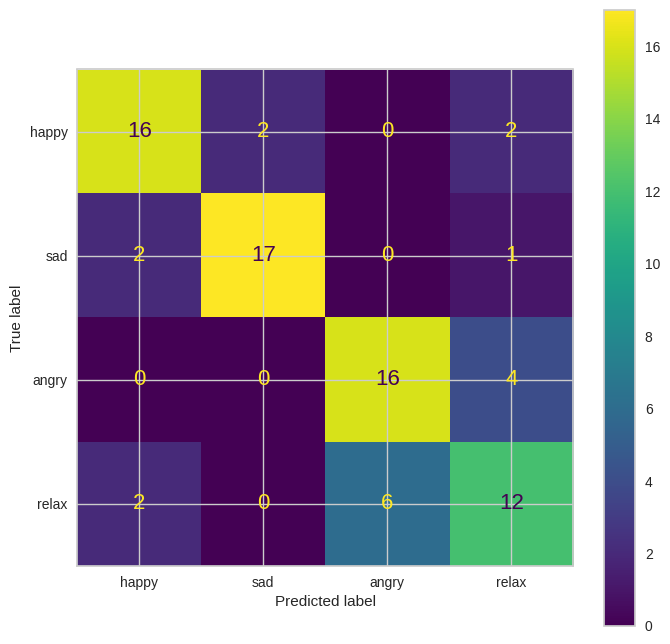

StackedClassifier SVM linear


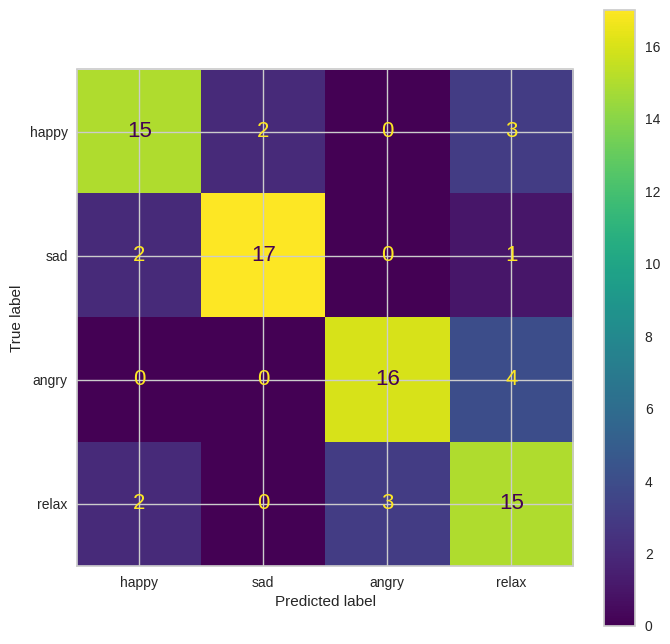

In [29]:
print("StackedClassifier LR")
plt.figure(figsize = (8, 8));
ConfusionMatrixDisplay.from_estimator(clf_lr, X_test_sc, Y_test, display_labels = [str(x) for x in Y_test.unique()], ax = plt.subplot());
plt.show()

print("StackedClassifier SVM linear")
plt.figure(figsize = (8, 8));
ConfusionMatrixDisplay.from_estimator(clf_lsvm, X_test_sc, Y_test, display_labels = [str(x) for x in Y_test.unique()], ax = plt.subplot());

Observamos lo que acabamos de comentar: **relax** es la clase con peor precisión mientras que **sad** es la clase con mejor precisión en ambos modelos.

Estos modelos son ambos mejor que el resto de modelos entrenados, ya que tienen las mejores precisiones en el conjunto de test (el modelo que cogeremos de StackedClassifier que usa como estimador final un modelo de SVM Linear tiene la mejor precisión de test de entre todos los modelos vistos).

### Calcula la permutation importance sobre el test para determinar qué atributos son más importantes en la mejor combinación. Compara los atributos más importantes con los de los apartados anteriores.
Cogeremos como mejor combinación de StackedClassifier la que usa SVM Linear como estimador final.

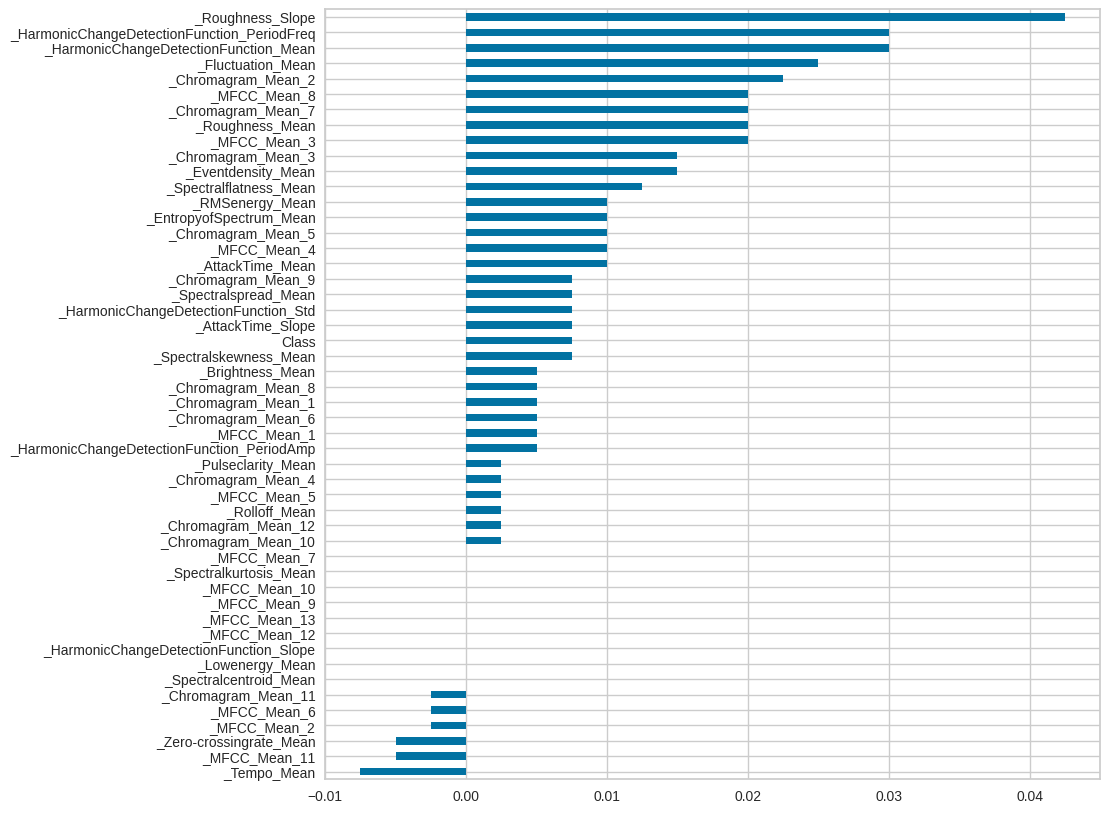

In [30]:
pi = permutation_importance(clf_lsvm, X_test_sc, Y_test, n_jobs = -1, random_state = 22)
var_imp = pd.DataFrame({'importance': pi.importances_mean}, index = musica.columns[:-1])
var_imp.sort_values(by = 'importance').plot.barh(figsize = (10, 10), legend = False);

Mirando los valores obtenidos con permutation importance, vemos que en este modelo, más de la mitad de variables (35) tienen cierta importancia.

Mirando a los resultados de permutation importance, podemos ver que las 5 variables más importantes para este modelo de StackedClassifier usando SVM Linear como estimador final son:
1. _Roughness_Slope
2. _HarmonicChangeDetectionFunction_PeriodFreq
3. _HarmonicChangeDetectionFunction_Mean
4. _Fluctuation_Mean
5. _Chromagram_Mean_2
   
Podemos ver que de las 5 variables más importantes, solo 1 coincide tanto con el modelo de regresión logística como con el de SVM lineal, con el de SVM con kernel RBF y con el de Random Forest: _HarmonicChangeDetectionFunction_Mean. Además, hay otra variable que coincide tanto con el modelo de SVM lineal como con el de SVM con kernel RBF y con el de Random Forest: _HarmonicChangeDetectionFunction_PeriodFreq. Hay también otra variable que coincide con los modelos de SVM (tanto Linear como con kernel RBF): _Roughness_Slope.

Podemos ver que casi no hay acuerdo entre los modelos respecto a qué atributos son más importantes (solo 1 coincide en los cinco modelos). Sin embargo, el modelo de StackedClassifier tiene 3 variables en común con dos modelos distintos (SMV linear y SVM con kernel RBF) y 2 variables en común Random Forest), y 3 de sus 5 variables más importantes aparecen entre las variables más importantes de alguno de los otros modelos, lo que indica que si hay cierto grado de acuerdo entre los modelos respecto a que variables son las más importantes, aunque no haya un consenso general.

Cabe destacar que a lo largo del problema, la evaluación de los modelos se ha realizado principalmente mediante accuracy (y no ROC-AUC), dado que las clases presentan una distribución totalmente equilibrada y el objetivo principal es la correcta clasificación final. Además, se ha usado KFold en vez de StratifiedKold ya que las clases estan perfectamente balanceadas (100 elementos de cada clase).